In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import h2o
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [2]:
data_dir = '../data/'
output_dir = '../output/'
date = "20251120"
featureset = 'featureset.csv'

In [3]:
figure_colors = [
    '#4269D0',  # blue
    '#FF8AB7',  # pink
    '#6CC5B0',  # teal
    '#2E3B4E',  # gray
    '#F5A623',  # orange
    '#9B72B0',  # purple
]

In [ ]:
h2o.init()

In [11]:
# Retrieve the ID and model name from the full path
def extract_modelname(input_string: str):
    last_slash_index = input_string.rfind('/')
    after_last_slash = input_string[last_slash_index + 1:]
    first_underscore_index = after_last_slash.find('_')
    id = after_last_slash
    name = after_last_slash[:first_underscore_index]
    return id,name

def acquire_models(path: str) -> dict:
    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith("best_model:"):
                best_model_path = line.strip().split(": ")[1]
                best_model_id,best_model_name= extract_modelname(best_model_path)
            elif line.startswith("second_model:"):
                second_model_path = line.strip().split(": ")[1]
                second_model_id,second_model_name= extract_modelname(second_model_path)
            elif line.startswith("third_model:"):
                third_model_path = line.strip().split(": ")[1]
                third_model_id,third_model_name= extract_modelname(third_model_path)
            
    models = {"best":{"id":best_model_id,"name":best_model_name,"path":best_model_path},
              "second":{"id":second_model_id,"name":second_model_name,"path":second_model_path},
              "third":{"id":third_model_id,"name":third_model_name,"path":third_model_path},
             }
    return models

models_full = acquire_models(f"{output_dir}/{date}/model_path/model_path_best_latest_full.txt")
models_minimum = acquire_models(f"{output_dir}/{date}/model_path/model_path_best_latest_minimum.txt")
models_compact = acquire_models(f"{output_dir}/{date}/model_path/model_path_best_latest_compact.txt")

In [12]:
best_model_full = h2o.load_model(models_full["best"]["path"])
best_model_minimum = h2o.load_model(models_minimum["best"]["path"])
best_model_compact = h2o.load_model(models_compact["best"]["path"])

In [13]:
def process_df(path_train: str, path_test: str, vars: list, label: str) -> None:
    train = h2o.import_file(os.path.join(data_dir, date, path_train))
    train = train[vars]
    test = h2o.import_file(os.path.join(data_dir, date, path_test))
    test = test[vars]

    y = label
    train[y] = train[y].asfactor()
    test[y] = test[y].asfactor()

    return train, test

In [14]:
df = pd.read_csv(os.path.join(data_dir,featureset))

#retrieve the features from the featureset for each model
minimum_model_features = df[df['minimum model'] == 1]['Feature'].tolist()
compact_model_features = df[df['compact model'] == 1]['Feature'].tolist()
full_model_features = df[df['full model'] == 1]['Feature'].tolist()

vars_full = full_model_features+['y']
vars_minimum = minimum_model_features+['y']
vars_compact = compact_model_features+['y']

In [ ]:
full_train, full_test = process_df(f'{date}_train_df.csv', f"{date}_test_df.csv", vars_full+["icu_stay_id"],'y')
minimum_train, minimum_test = process_df(f'{date}_train_df.csv', f"{date}_test_df.csv", vars_minimum,'y')
compact_train, compact_test = process_df(f'{date}_train_df.csv', f"{date}_test_df.csv", vars_compact,'y')

### Calculate AUROC, AUPRC, SHAP using models

In [16]:
perf_full= best_model_full.model_performance(full_test)
perf_minimum = best_model_minimum.model_performance(minimum_test)
perf_compact = best_model_compact.model_performance(compact_test)

In [ ]:
# Calculate the AUROC
auroc_full = perf_full.auc()
auroc_minimum = perf_minimum.auc()
auroc_compact = perf_compact.auc()
print(f"model full Test AUROC: {auroc_full}")
print(f"model minimum Test AUROC: {auroc_minimum}")
print(f"model compact Test AUROC: {auroc_compact}")

In [ ]:
best_predict_full = best_model_full.predict(full_test)
full_test['predict_all_model'] = best_predict_full['p1']
best_predict_df_full = full_test.as_data_frame()

In [ ]:
best_predict_minimum = best_model_minimum.predict(minimum_test)
minimum_test['predict_all_model'] = best_predict_minimum['p1']
best_predict_df_minimum = minimum_test.as_data_frame()

In [ ]:
best_predict_compact = best_model_compact.predict(compact_test)
compact_test['predict_all_model'] = best_predict_compact['p1']
best_predict_df_compact = compact_test.as_data_frame()

### ROC Plot

In [ ]:
score_df = pd.read_csv(os.path.join(data_dir, date, "20251120_test_df.csv"))

# calculate ROC for each score
fpr_isth, tpr_isth, _ = roc_curve(score_df['y'], score_df['isth_dic_score'])
auc_isth = auc(fpr_isth, tpr_isth)

fpr_sic, tpr_sic, _ = roc_curve(score_df['y'], score_df['sic_score'])
auc_sic = auc(fpr_sic, tpr_sic)

fpr_jaam, tpr_jaam, _ = roc_curve(score_df['y'], score_df['jaam_dic_score'])
auc_jaam = auc(fpr_jaam, tpr_jaam)

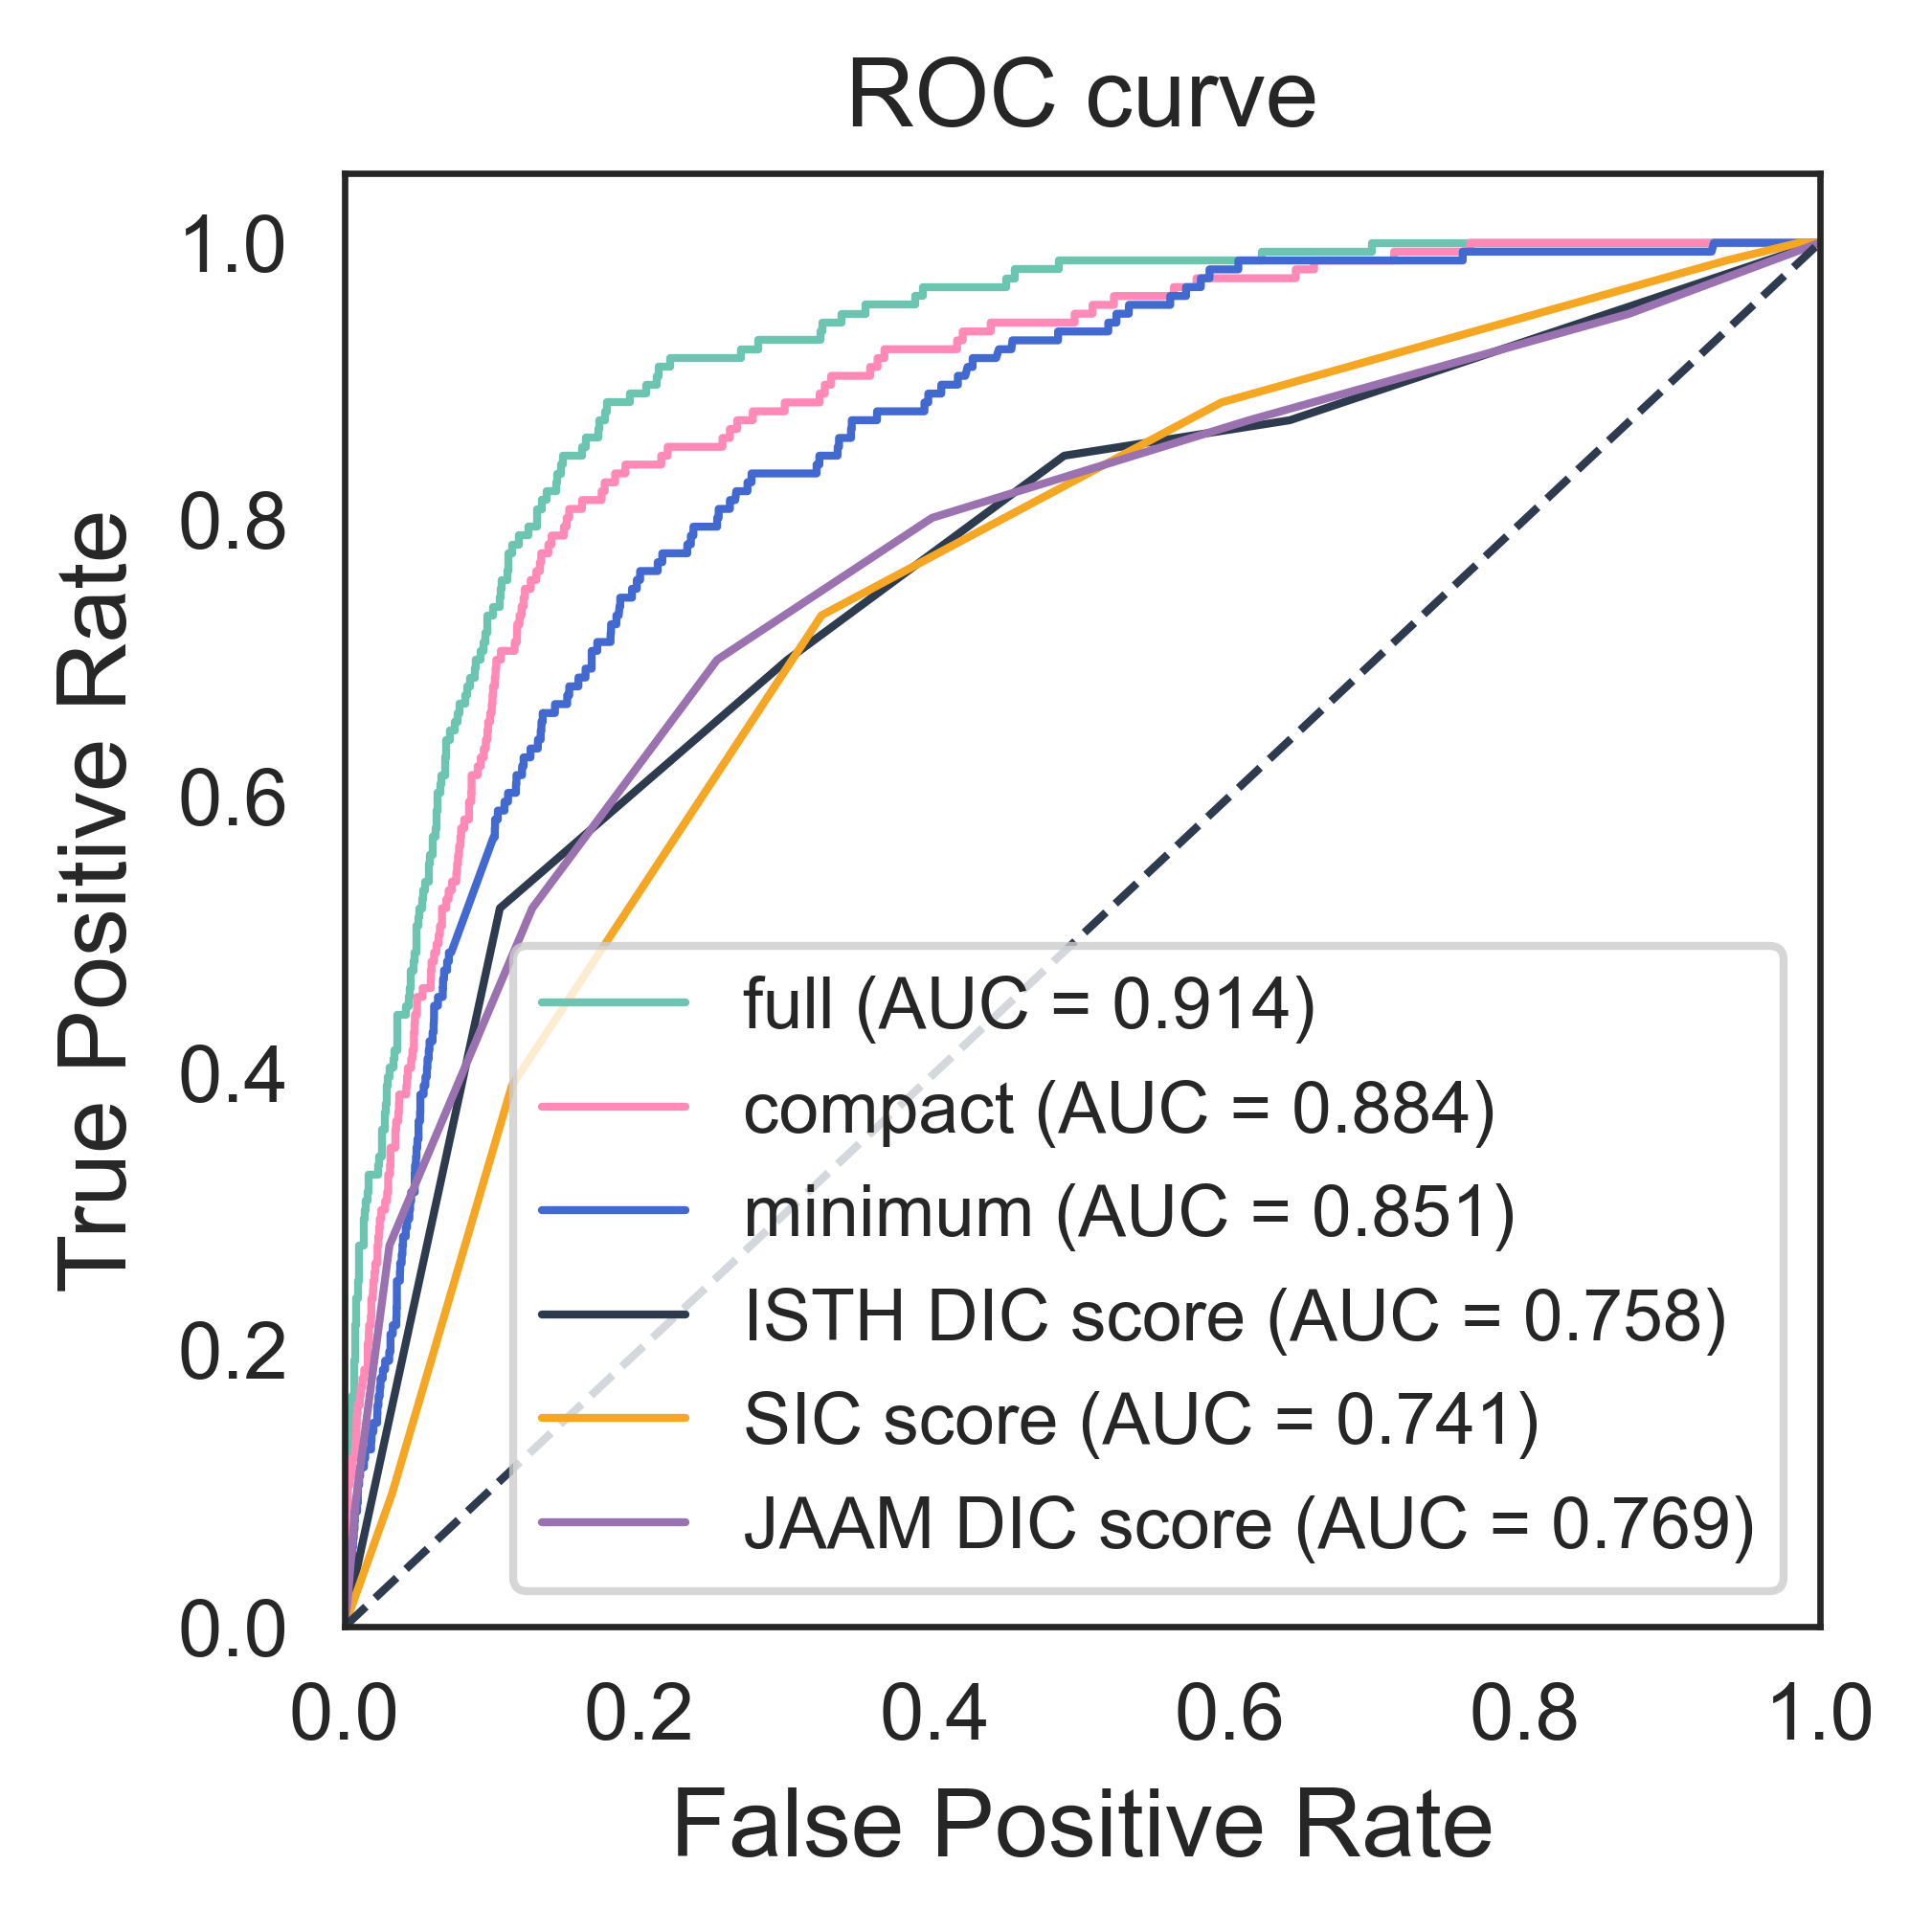

In [ ]:
# Compute ROC curve and ROC area
fpr1, tpr1, _ = roc_curve(best_predict_df_full['y'], best_predict_df_full['predict_all_model'])
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(best_predict_df_minimum['y'], best_predict_df_minimum['predict_all_model'])
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(best_predict_df_compact['y'], best_predict_df_compact['predict_all_model'])
roc_auc3 = auc(fpr3, tpr3)


width_in_inches = 88 / 25.4
height_in_inches = 88 / 25.4
dpi = 600


# Plotting the ROC curve
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(width_in_inches,height_in_inches),dpi=dpi)
sns.set_style("white")
plt.plot(fpr1, tpr1, color=figure_colors[2], lw=1, label=f'full (AUC = {roc_auc1:.3f})')
plt.plot(fpr3, tpr3, color=figure_colors[1], lw=1, label=f'compact (AUC = {roc_auc3:.3f})')
plt.plot(fpr2, tpr2, color=figure_colors[0], lw=1, label=f'minimum (AUC = {roc_auc2:.3f})')
plt.plot(fpr_isth, tpr_isth, color=figure_colors[3], lw=1, linestyle='-', label=f'ISTH DIC score (AUC = {auc_isth:.3f})')
plt.plot(fpr_sic, tpr_sic,color=figure_colors[4], lw=1, linestyle='-', label=f'SIC score (AUC = {auc_sic:.3f})')
plt.plot(fpr_jaam, tpr_jaam, color=figure_colors[5], lw=1, linestyle='-', label=f'JAAM DIC score (AUC = {auc_jaam:.3f})')


plt.plot([0, 1], [0, 1], color=figure_colors[3], lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve', fontsize=12)
plt.legend(loc="lower right", fontsize=9)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f'figures/{date}_ROC_curve_3best.tiff'))
plt.show()

In [ ]:
def compute_metrics_first_exceed(df, target_sens=0.8, target_spe=0.8):
    y = df["y"].values
    pred = df["predict_all_model"].values

    # ROC
    fpr, tpr, thresholds = roc_curve(y, pred)
    specificity = 1 - fpr

    mask_sens = tpr >= target_sens
    if np.any(mask_sens):
        idx_sens = np.where(mask_sens)[0][0]
        thr_sens = thresholds[idx_sens]
        y_pred_sens = (pred >= thr_sens).astype(int)
        TP = ((y_pred_sens == 1) & (y == 1)).sum()
        FP = ((y_pred_sens == 1) & (y == 0)).sum()
        TN = ((y_pred_sens == 0) & (y == 0)).sum()
        FN = ((y_pred_sens == 0) & (y == 1)).sum()
        spe_at_sens = TN / (TN + FP)
        ppv_at_sens = TP / (TP + FP) if (TP + FP) > 0 else np.nan
    else:
        spe_at_sens = np.nan
        ppv_at_sens = np.nan

    mask_spe = specificity >= target_spe
    if np.any(mask_spe):
        idx_last_true = np.where(mask_spe)[0][-1]
        idx_spe = idx_last_true + 1 if idx_last_true + 1 < len(tpr) else idx_last_true
        thr_spe = thresholds[idx_spe]
        y_pred_spe = (pred >= thr_spe).astype(int)
        TP2 = ((y_pred_spe == 1) & (y == 1)).sum()
        FP2 = ((y_pred_spe == 1) & (y == 0)).sum()
        TN2 = ((y_pred_spe == 0) & (y == 0)).sum()
        FN2 = ((y_pred_spe == 0) & (y == 1)).sum()
        sens_at_spe = TP2 / (TP2 + FN2)
        npv_at_spe = TN2 / (TN2 + FN2) if (TN2 + FN2) > 0 else np.nan
    else:
        sens_at_spe = np.nan
        npv_at_spe = np.nan

    return {
        "Spe_at_Sens90": spe_at_sens.round(4),
        "PPV_at_Sens90": ppv_at_sens.round(4),
        "Sens_at_Spe90": sens_at_spe.round(4),
        "NPV_at_Spe90": npv_at_spe.round(4)
    }

full_metrics = compute_metrics_first_exceed(best_predict_df_full)
compact_metrics = compute_metrics_first_exceed(best_predict_df_compact)
base_metrics = compute_metrics_first_exceed(best_predict_df_minimum)

# 表にまとめる
result_df = pd.DataFrame({
    "Full": full_metrics,
    "Compact": compact_metrics,
    "Base": base_metrics
}).T

result_df

,Spe_at_Sens90,PPV_at_Sens90,Sens_at_Spe90,NPV_at_Spe90
Full,0.8692,0.1427,0.8910,0.9963
Compact,0.8493,0.1254,0.8397,0.9946
Base,0.7473,0.0788,0.7564,0.9919


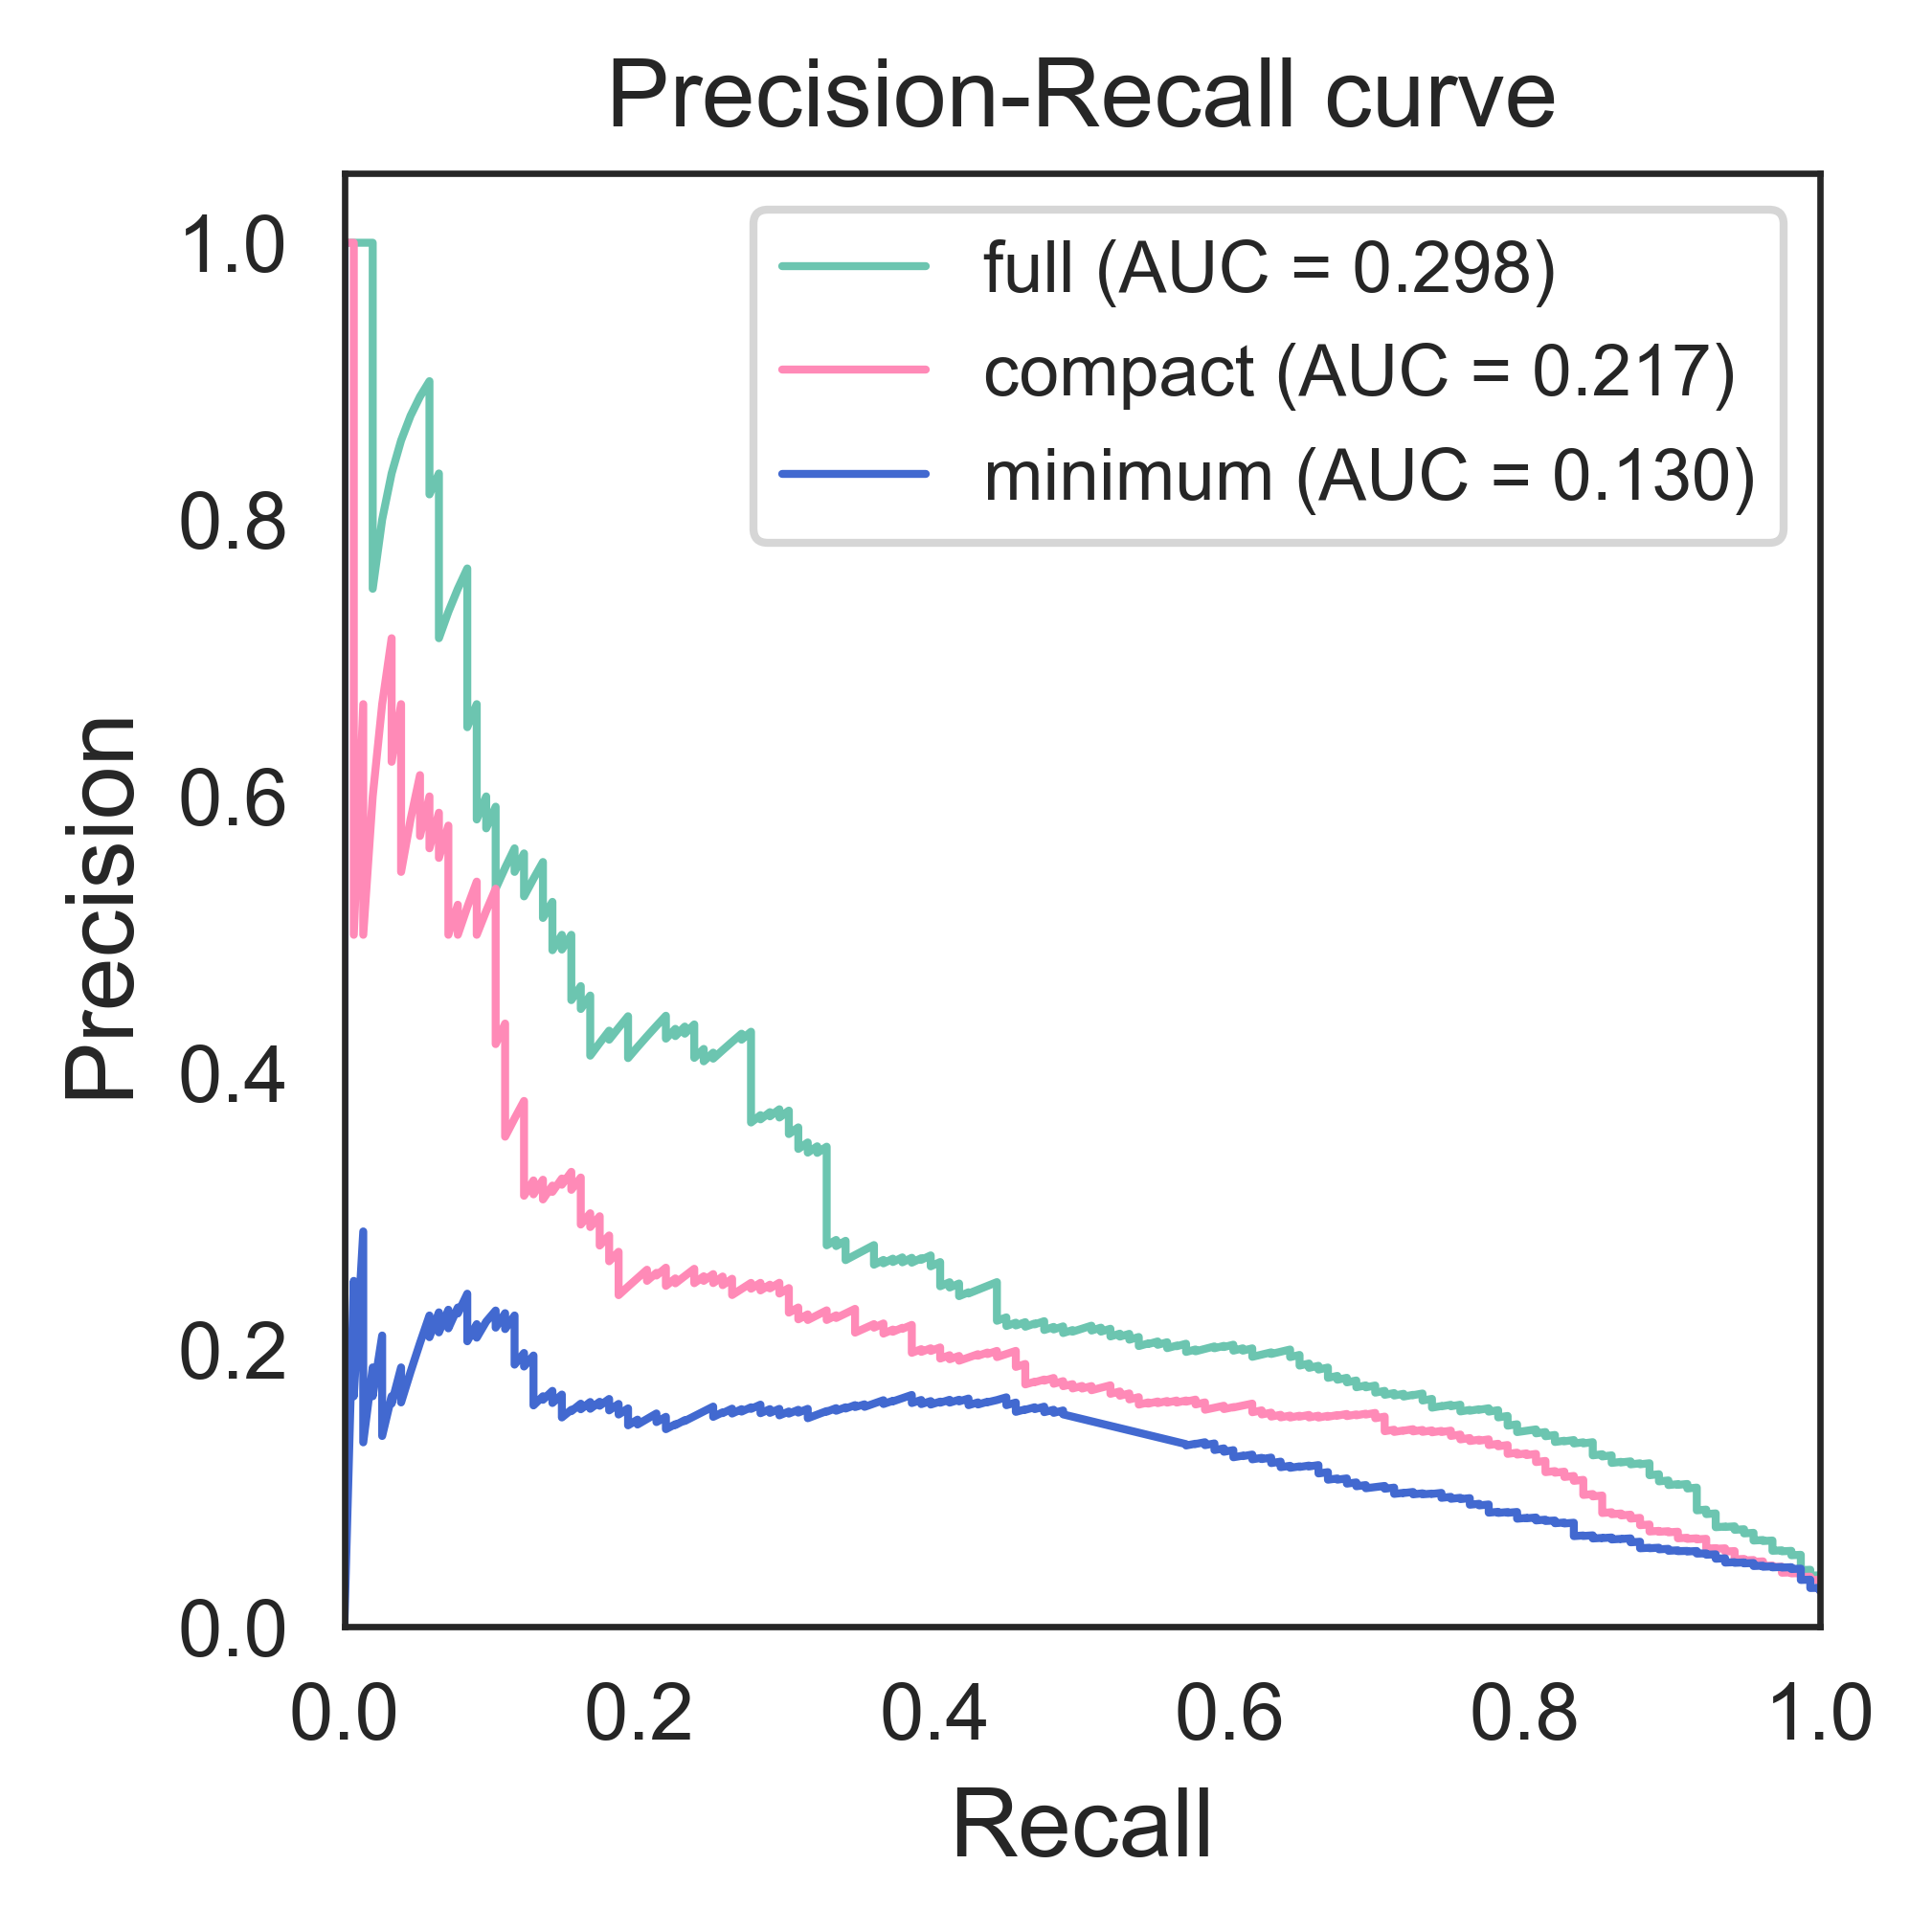

In [ ]:
# Compute Precision-Recall curve and area for "full" model
precision1, recall1, _ = precision_recall_curve(best_predict_df_full['y'], best_predict_df_full['predict_all_model'])
pr_auc1 = auc(recall1, precision1)
precision2, recall2, _ = precision_recall_curve(best_predict_df_compact['y'], best_predict_df_compact['predict_all_model'])
pr_auc2 = auc(recall2, precision2)
precision3, recall3, _ = precision_recall_curve(best_predict_df_minimum['y'], best_predict_df_minimum['predict_all_model'])
pr_auc3 = auc(recall3, precision3)

prec_isth, rec_isth, _ = precision_recall_curve(score_df['y'], score_df['isth_dic_score'])
auc_isth_pr = auc(rec_isth, prec_isth)

prec_sic, rec_sic, _ = precision_recall_curve(score_df['y'], score_df['sic_score'])
auc_sic_pr = auc(rec_sic, prec_sic)

prec_jaam, rec_jaam, _ = precision_recall_curve(score_df['y'], score_df['jaam_dic_score'])
auc_jaam_pr = auc(rec_jaam, prec_jaam)

# Define figure size and DPI
width_in_inches = 88 / 25.4
height_in_inches = 88 / 25.4
dpi = 600

# Plotting the Precision-Recall curve for the full model
plt.rcParams['font.family'] = 'Arial'

plt.figure(figsize=(width_in_inches, height_in_inches), dpi=dpi)
sns.set_style("white")

# Plot the Precision-Recall curve for full model
plt.plot(recall1, precision1, color=figure_colors[2], lw=1, label=f'full (AUC = {pr_auc1:.3f})')
plt.plot(recall2, precision2, color=figure_colors[1], lw=1, label=f'compact (AUC = {pr_auc2:.3f})')
plt.plot(recall3, precision3, color=figure_colors[0], lw=1, label=f'minimum (AUC = {pr_auc3:.3f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall curve', fontsize=12)
plt.legend(loc="upper right", fontsize=9)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# Adjust layout to avoid cutting off labels
plt.tight_layout()

# Save the plot
plt.savefig(os.path.join(output_dir, f'figures/{date}_PR_curve_full.tiff'))
plt.show()

### SHAP socre

In [ ]:
model_explanation_beta = h2o.get_model(models_full["best"]["id"])

In [ ]:
# drop enum type variable
full_test = full_test.drop(['y'])

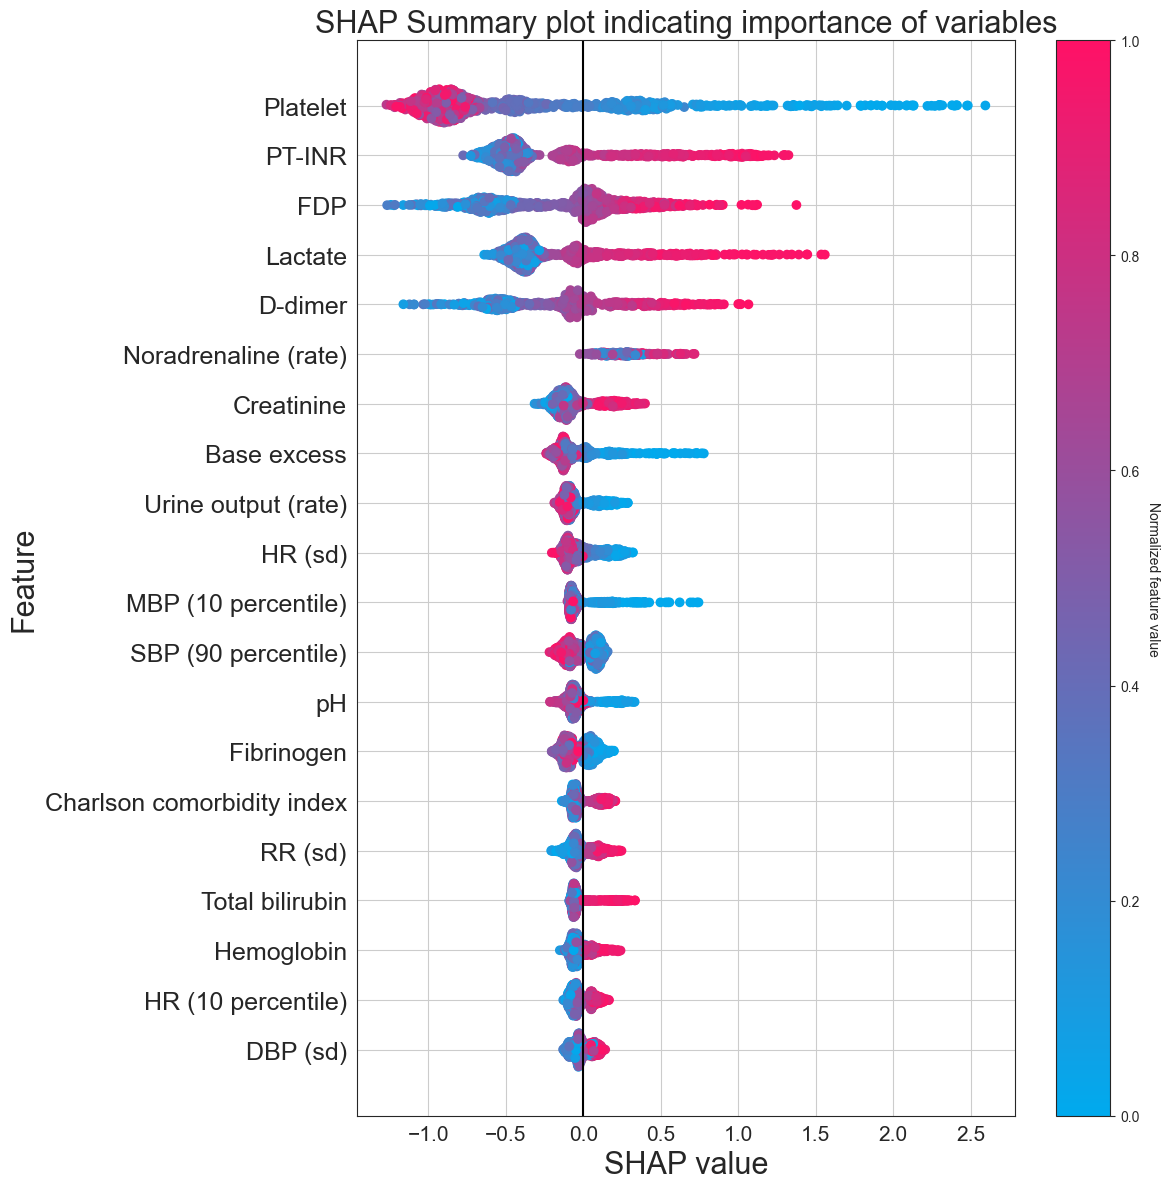

In [ ]:
shap_plot = model_explanation_beta.shap_summary_plot(full_test,top_n_features=20,figsize=(12, 12))
plt.title("SHAP Summary plot indicating importance of variables", fontsize=22)
plt.xlabel(plt.gca().get_xlabel(), fontsize=22)
plt.ylabel(plt.gca().get_ylabel(), fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=18)
plt.tight_layout()

plt.savefig(os.path.join(output_dir, f'figures/{date}_SHAP_full.tiff'))
plt.savefig(os.path.join(output_dir, f'figures/{date}_SHAP_full.tiff'), format='tiff')
plt.show()